# Libraries

In [1]:
# Main Libraries
import pandas as pd
import numpy as np
from numpy.linalg import inv

# Support Libraries
import os
import math
import random
import time
import warnings
warnings.filterwarnings("ignore")

# Learning Libraries
import sklearn.datasets as ds
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Data Import

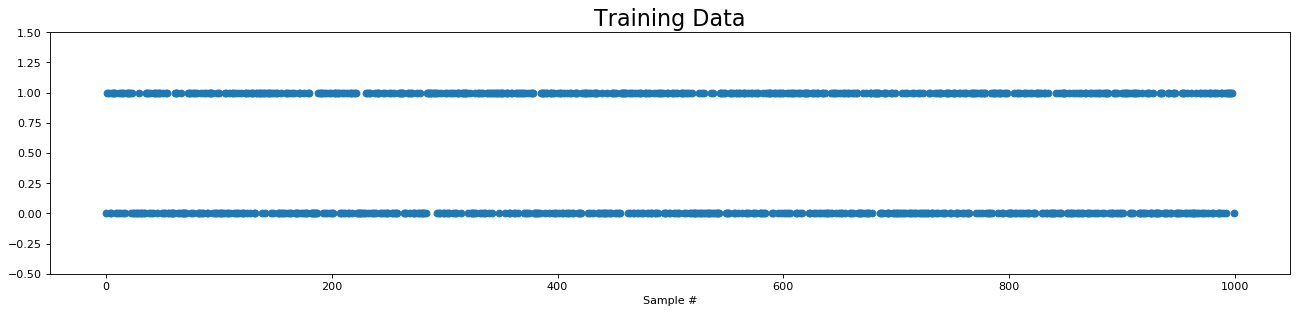

Time --- Minutes --- 0.0


In [2]:
start_time = time.time()

#####################################################################################################

number_features = 30
number_samples = 1000

x,y = ds.make_classification(n_samples = number_samples,
                             n_features = number_features,
                             n_redundant = 0,
                             n_informative = 30,
                             n_classes = 2)

# Normalize inputs into a normal distribution
# x = StandardScaler().fit_transform(x)

# Append 1's for bias paramters
x = np.append(x, np.ones((number_samples,1)), axis=1)

# Reshape y
y = y.reshape(-1, 1)

# Plot training data
plt.figure(figsize=(20, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y, 'o');
plt.ylim(np.min(y)-0.5, np.max(y)+0.5)
plt.xlabel('Sample #')
plt.title('Training Data', fontsize=20)
plt.show()

#####################################################################################################

print("Time --- Minutes ---", np.round((time.time() - start_time) / 60, decimals=2))

# Logistic Regression

In [3]:
start_time = time.time()

#####################################################################################################

class model_train:
    def __init__(self, num_samples, num_features, num_iterations, tolerance, eta):
        self.num_samples = num_samples
        self.num_features = num_features
        self.num_iterations = num_iterations
        self.tolerance = tolerance
        self.eta = eta
        self.train_losses = []
    
    # Sigmoid Function
    def sigmoid(self, z):
        return np.divide(1., (1 + np.exp(-z)))
    
    # Initialize Parameters
    # Return a matrix of paramters with dimensions equal to training data + an appended column of paramters to the bias terms
    def initialize_paramters(self):
        return 1.0 * (np.random.rand(self.num_features+1, 1))

    # Cost Function
    def cost_function(self, train_y_sample, y_pred):
        part_one = np.dot(train_y_sample.T, np.log(y_pred))
        part_two = np.dot((1 - train_y_sample.T), (1 - np.log(y_pred)))
        l = -(part_one + part_two) / self.num_samples
        return np.round(l, 2)
    
    # Training Paramters
    def train_model(self, train_x, train_y):
        # Initial Paramters
        train_theta = self.initialize_paramters()
        
        # Train Model
        i = 1
        while(i <= self.num_iterations):
            # Log Regression Classifier
#             y_pred = self.sigmoid(np.dot(train_x, train_theta))

            # Decision Tree Classifier
            clf = tree.DecisionTreeClassifier()
            y_pred = clf.fit(train_x, train_y)
            y_pred = clf.predict(train_x).reshape(-1, 1)
            
            # Evaluate Model
            err_list = np.where(y_pred != train_y)
            err_mismatch = len(err_list[0])
            
            if((err_mismatch <= self.tolerance)):
                break
            else:
                # Compute Cost Function
#                 cost = self.cost_function(train_y_sample, y_pred)
                cost = metrics.log_loss(y_true=train_y, y_pred=y_pred)
#                 self.train_losses.append(cost)
                self.train_losses.append(err_mismatch)
                # Update Paramters
#                 train_theta = train_theta + (self.eta * np.dot(train_x.T, (train_y - y_pred)))
            i += 1
        return train_theta, self.train_losses, y_pred

#####################################################################################################

class adaboost_method:
    def __init__(self, x_train, y_train, num_samples, num_features, num_models, num_iterations, tolerance, eta):
        self.x_train = x_train
        self.x_train_d = x_train
        self.y_train = y_train
        self.y_train_d = y_train
        self.num_models = num_models
        self.tolerance = (tolerance / 100) * num_samples
        self.d = np.ones((num_samples, 1)) * (1 / num_samples) 
        self.model_theta = []
        self.model_losses = []
        self.model_pred = []
        self.model_err = []
        self.model_alpha = []
        
        # Initalization of Training Class
        self.model_train_class = model_train(num_samples, num_features, num_iterations, self.tolerance, eta)
    
    # AdaBoosting
    def adaboosting(self):
        j = 1
        while(j <= self.num_models):
            # Train Model
            theta, model_loss, y_pred = self.model_train_class.train_model(self.x_train_d, self.y_train_d)
            self.model_theta.append(theta)
            self.model_losses.append(model_loss)
            
            # Number of misclassified classes in each boost with train data
            y_pred_iteration = np.round(self.model_train_class.sigmoid(np.dot(self.x_train, theta)))
            self.model_pred.append(y_pred_iteration)
            err_list = np.where(y_pred_iteration != self.y_train)
            err = np.round(len(err_list[0]) / len(y), 3) * 100
            self.model_err.append(err)
            
            # Number of misclassified classes in each boost with misclassified data
            y_pred_iteration_d = np.round(self.model_train_class.sigmoid(np.dot(self.x_train_d, theta)))
            err_list = np.where(y_pred_iteration_d != self.y_train_d)

            # AdaBoost Weights Adjusting
            d_err = self.d[err_list[0]]
            d_err_sum = self.d[err_list[0]].sum() / self.d.sum()
            alpha = (np.log((1 - d_err_sum) / (d_err_sum+0.0001))) / 2
            self.model_alpha.append(alpha)
            e_alpha_pos = np.exp(alpha)
            e_alpha_neg = np.exp(-alpha)

            # Boost Misclassified Samples
            d_err = d_err * np.exp(alpha)
            self.x_train_d = self.x_train_d[err_list[0]]
            self.x_train_d = self.x_train_d * d_err
            self.y_train_d = self.y_train_d[err_list[0]]
            j += 1
            
        y_pred_final =  [self.model_pred[i] * self.model_alpha[i] for i in range(len(self.model_alpha))]
        y_pred_final = np.round(sum(y_pred_final))
        return self.model_theta, self.model_losses, self.model_pred, self.model_err, self.model_alpha, y_pred_final

#####################################################################################################

# Run Model
adaboost_class = adaboost_method(x_train = x, 
                                 y_train = y, 
                                 num_samples = number_samples, 
                                 num_features = number_features, 
                                 num_models = 5, 
                                 num_iterations = 10, 
                                 tolerance = 5, 
                                 eta = 0.01)
model_theta, model_losses, model_pred, model_err, model_alpha, y_pred_final = adaboost_class.adaboosting()

print(np.round(model_err, 4))
model_winner = np.argmin(model_err)
print('Winner: ', model_winner+1)
print(np.round(model_alpha, 4))

#####################################################################################################

print(); print("Time --- Minutes ---", np.round((time.time() - start_time) / 60, decimals=2))

[45.8 41.  40.4 43.2 48.2]
Winner:  3
[0.0841 0.3517 0.5048 0.5761 0.6096]

Time --- Minutes --- 0.0


% of Misclassified Classes                   :  45.800000000000004
% of Misclassified Classes - AdaBoost Winner :  40.400000000000006
% of Misclassified Classes - AdaBoost Final  :  72.0


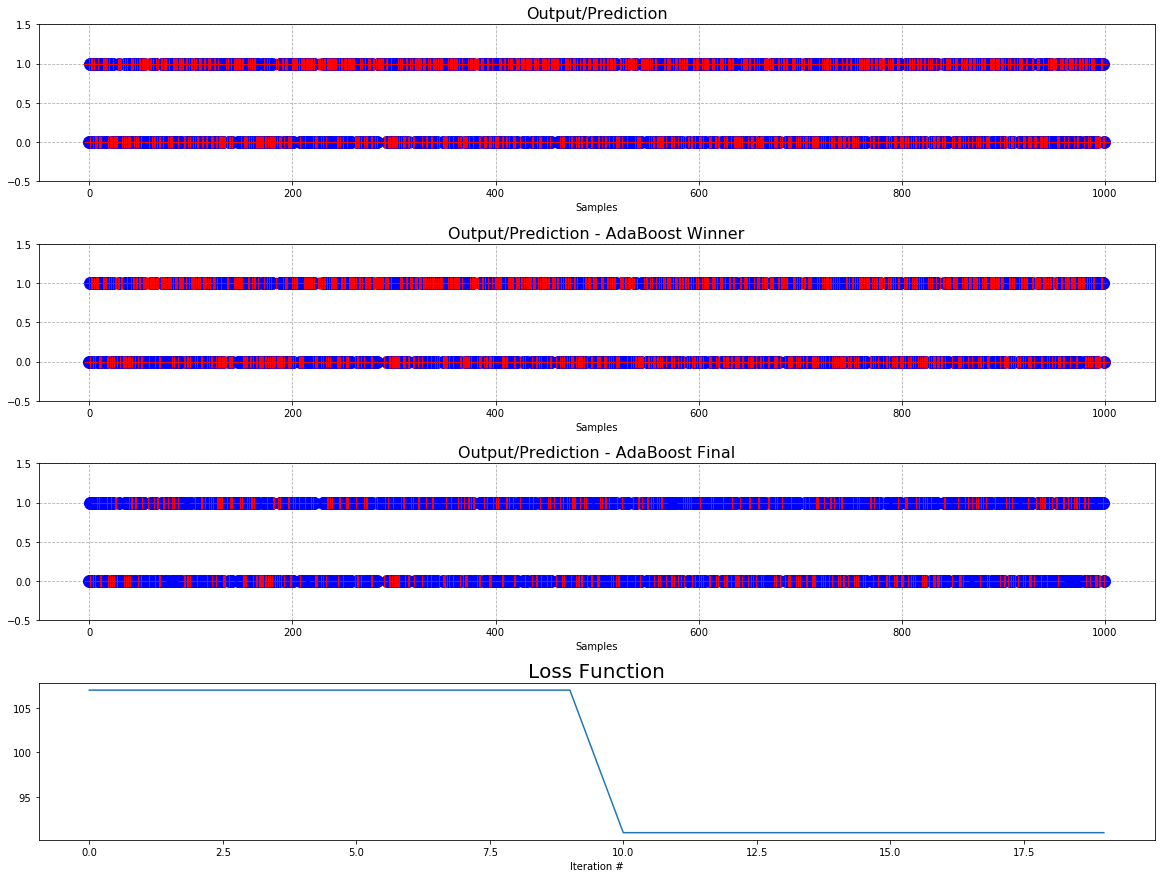


Time --- Minutes --- 0.01


In [4]:
start_time = time.time()

#####################################################################################################

model_zero_theta = model_theta[0]
model_zero_losses = np.array(model_losses[0]).reshape(-1 ,1)
y_zero_pred = np.round(adaboost_class.model_train_class.sigmoid(np.dot(x, model_zero_theta)))
err = np.round(len(np.where(y_zero_pred != y)[0]) / len(y), 3) * 100
print('% of Misclassified Classes                   : ', err)

model_winner_theta = model_theta[model_winner]
y_winner_pred = np.round(adaboost_class.model_train_class.sigmoid(np.dot(x, model_winner_theta)))
err = np.round(len(np.where(y_winner_pred != y)[0]) / len(y), 3) * 100
print('% of Misclassified Classes - AdaBoost Winner : ', err)

err = np.round(len(np.where(y_pred_final != y)[0]) / len(y), 3) * 100
print('% of Misclassified Classes - AdaBoost Final  : ', err)

#####################################################################################################

fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4, 1, figsize=(20, 15))
ax1.set_title('Output/Prediction', fontsize=16)
ax1.set_xlabel('Samples')
ax1.plot(y, 'o', markersize=12, color='b')
ax1.plot(y_zero_pred, '+', markersize=12, color='r')
ax1.grid(True, which='both', linestyle='--')
ax1.set_ylim(np.min(y)-0.5, np.max(y)+0.5)

ax2.set_title('Output/Prediction - AdaBoost Winner', fontsize=16)
ax2.set_xlabel('Samples')
ax2.plot(y, 'o', markersize=12, color='b')
ax2.plot(y_winner_pred, '+', markersize=12, color='r')
ax2.grid(True, which='both', linestyle='--')
ax2.set_ylim(np.min(y)-0.5, np.max(y)+0.5)

ax3.set_title('Output/Prediction - AdaBoost Final', fontsize=16)
ax3.set_xlabel('Samples')
ax3.plot(y, 'o', markersize=12, color='b')
ax3.plot(y_pred_final, '+', markersize=12, color='r')
ax3.grid(True, which='both', linestyle='--')
ax3.set_ylim(np.min(y)-0.5, np.max(y)+0.5)

ax4.plot(model_zero_losses)
ax4.set_title('Loss Function', fontsize=20)
ax4.set_xlabel('Iteration #')

plt.subplots_adjust(hspace = 0.4)
plt.show()

#####################################################################################################

print(); print("Time --- Minutes ---", np.round((time.time() - start_time) / 60, decimals=2))